# Snake

In [12]:
from environments import *
import tensorflow as tf
import numpy as np
from IPython.display import clear_output
from  tqdm import trange
import matplotlib.pyplot as plt
import keras.api._v2.keras as K
import os
import json

## Environment definition

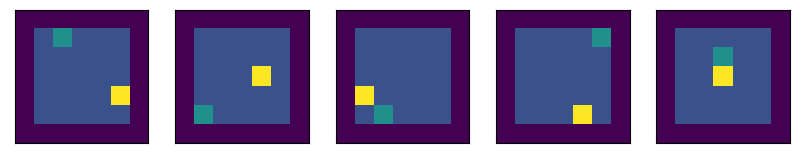

In [13]:
%matplotlib inline
def get_env(n=1000):
    return OriginalSnakeEnvironment(n, 7)
env_ = get_env()
# reward discount
GAMMA = .99
# number of iterations for the training (snake steps)
ITERATIONS = 5000
# Eps to add to the policy probabilities to ensure a bit of exploration
EPSILON = 0.1
# lambda parameters for value and policy wrt eligibility traces
LAMBDA_VALUE = 0.1
LAMBDA_AGENT = 0.1
# percentage of boards to sample each time for the gradient estimation
# used to de-correlate gradients
PERCENTAGE_TO_HOLD = .5

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## Demo

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
demo_env = get_env(5)
def animate(_):
    original_probs = tf.convert_to_tensor([[.25]*4]*demo_env.n_boards)
    mask = get_probabilities_mask(demo_env.boards, original_probs.shape)
    probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]
    actions = tf.random.categorical(tf.math.log(probs),1)
    demo_env.move(actions)
    for board, image in zip(demo_env.boards, images):
        image.set_data(board)
    return images

In [15]:
fig, axs = plt.subplots(1,demo_env.n_boards, figsize=(10,3))
images = []
for b, ax in zip(demo_env.boards, axs.flatten()):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>

## Model

In [16]:
input = K.layers.Input(shape=(env_.board_size, env_.board_size, 5))
x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

if env_.board_size > 8:
    x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)
if env_.board_size > 10:
    x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)
if env_.board_size > 12:
    x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)
if env_.board_size > 13:
    x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)
x = K.layers.Flatten()(x)
policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(4, activation=tf.nn.softmax)(policy)
agent = K.models.Model(inputs=input, outputs=policy)




input = K.layers.Input(shape=(env_.board_size, env_.board_size, 5))
x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

if env_.board_size > 8:
    x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)
if env_.board_size > 10:
    x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)
if env_.board_size > 12:
    x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)
if env_.board_size > 13:
    x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)
x = K.layers.Flatten()(x)
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(1, activation="linear")(vf)
value = K.models.Model(inputs=input, outputs=vf)

In [17]:
MODELS_PREFIX = f"models/{type(env_).__name__}/{env_.board_size}x{env_.board_size}"
os.makedirs(MODELS_PREFIX, exist_ok=True)

In [18]:
try:
    agent.load_weights(MODELS_PREFIX+f"/agent")
    value.load_weights(MODELS_PREFIX+f"/value")
    print("loaded")
except:
    pass

## Training

In [19]:
optimizer_value = K.optimizers.Adam(1e-3)
optimizer_agent = K.optimizers.Adam(1e-5)

In [20]:
avg_rewards = []

In [21]:
try :
    import json
    with open(f"{MODELS_PREFIX}/training.txt", "r") as file:
        avg_rewards = json.load(file)
    print("loaded")
except:
    pass

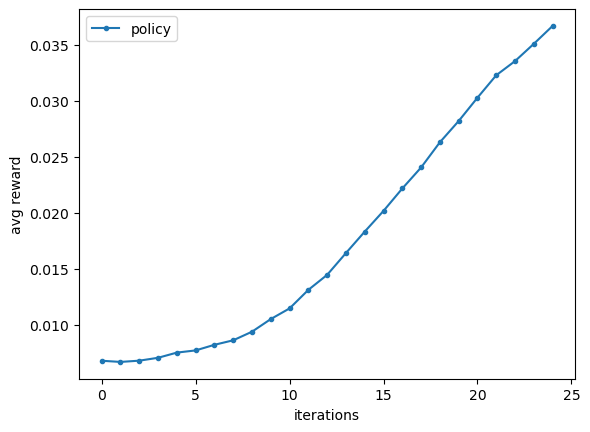

100%|██████████| 5000/5000 [03:35<00:00, 23.25it/s]


In [22]:
%matplotlib inline
eligibility_trace_agent = [tf.zeros_like(layer) for layer in agent.trainable_weights]
eligibility_trace_value = [tf.zeros_like(layer) for layer in value.trainable_weights]
for _ in trange(ITERATIONS):
    state = env_.to_state()
    decorrelation_mask = tf.convert_to_tensor(
        np.random.choice([0.,1.], env_.n_boards, p=(1-PERCENTAGE_TO_HOLD,PERCENTAGE_TO_HOLD)),dtype=tf.float32)[...,None]
    with tf.GradientTape(persistent=True) as tape:
        # calculate distributions of actions + epsilon to avoid stop exploring (it will be normalized in the next call)
        original_probs = agent(state) + EPSILON

        # remove actions that are not available and re-normalize
        # either multiply by 0 and normalize with L1, or add -inf and use softmax
        # use np.finfo(np.float32).min instead of -np.inf
        mask = get_probabilities_mask(env_.boards, original_probs.shape)
        probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]

        # sample actions
        actions = tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)

        # MDP update
        rewards = env_.move(actions)
        new_state = tf.constant(env_.to_state())

        # TD error
        value_state = tf.constant(value(state))
        new_value_state = tf.constant(value(new_state))
        td_error = tf.stop_gradient((rewards + GAMMA * new_value_state) - value_state) * -1

        # calculate the loss for both value and agent
        loss_agent = tf.stop_gradient(td_error) * -tf.losses.sparse_categorical_crossentropy(actions,probs)[...,None]
        loss_value = tf.stop_gradient(td_error) * value_state
        loss_agent = tf.reduce_mean(loss_agent * decorrelation_mask)
        loss_value = tf.reduce_mean(loss_value * decorrelation_mask)

    avg_rewards.append(tf.reduce_mean(rewards))

    if LAMBDA_AGENT > 0 or LAMBDA_VALUE > 0:
        # calculate gradient
        gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
        gradient_value = tape.gradient(loss_value, value.trainable_weights)
        # update eligibility traces
        eligibility_trace_agent = [GAMMA * LAMBDA_AGENT * layer + gradient for layer, gradient in zip(eligibility_trace_agent, gradient_agent)]
        eligibility_trace_value = [GAMMA * LAMBDA_VALUE * layer + gradient for layer, gradient in zip(eligibility_trace_value, gradient_value)]

        # update neural nets weights
        optimizer_value.apply_gradients(zip(eligibility_trace_value, value.trainable_weights))
        optimizer_agent.apply_gradients(zip(eligibility_trace_agent, agent.trainable_weights))
    else:
        optimizer_value.minimize(loss_value, value.trainable_weights, tape=tape)
        optimizer_agent.minimize(loss_agent, agent.trainable_weights, tape=tape)


    # every 200 iterations, plot the avg reward of each chunk of 100 iterations, and save the models
    if len(avg_rewards) % 200 == 0 and len(avg_rewards) > 0:
        # clear output
        clear_output(wait=True)
        # plot
        points = np.array(avg_rewards).reshape((-1, 200)).mean(axis=-1)
        plt.plot(points, marker=".")
        _ = plt.xlabel("iterations")
        _ = plt.ylabel("avg reward")
        plt.legend(["policy"])
        plt.show()
        # save
        with open(f"{MODELS_PREFIX}/training.txt", "w+") as file:
            json.dump(np.array(avg_rewards).tolist(), file)
        agent.save_weights(f"{MODELS_PREFIX}/agent")
        value.save_weights(f"{MODELS_PREFIX}/value")


### Random policy reward

In [23]:
random_env = get_env(1000)
random_rewards = []

for _ in trange(1000):
    original_probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    mask = get_probabilities_mask(random_env.boards, original_probs.shape)
    probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(tf.reduce_mean(rewards))

100%|██████████| 1000/1000 [00:11<00:00, 85.47it/s]


## Training evaluation

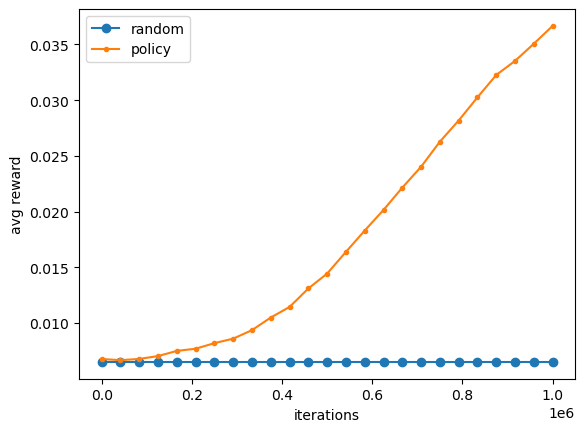

In [24]:
%matplotlib inline

CHUNK_SIZE = 200
N = len(avg_rewards)//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
plt.plot(x, np.array(random_rewards[500:]).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])

## Test (graphical simulation)

In [25]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [26]:
test_env = get_env(3)

In [27]:
def animate(_):
    original_probs = tf.concat((agent(
        test_env.to_state()
    )[:-1], [[.25]*4]), axis=0)

    mask = get_probabilities_mask(test_env.boards, original_probs.shape)
    probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]

    actions = tf.random.categorical(tf.math.log(probs),1)
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [28]:
# first three are policy guided, the fourth is random, to give a comparison
fig, axs = plt.subplots(1,3, figsize=(12,5))
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>